# Dynamical system signal filtering

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### System parameters and simulation
Let us consider a simple joint described by $J\dot \omega + b\omega = u$

In [2]:
# Parameters and simulation
J = 0.01       # inertia [kg*m^2]
b = 0.1        # damping [N*m*s/rad]
T = 5.0        # total simulation time [s]
dt = 0.001     # time step [s]
n_steps = int(T / dt)
t = np.linspace(0, T, n_steps)


# Input: step torque (you can change to any signal)
u = 0.05 * np.ones_like(t)
u[t > 1.0] = 0.1  # small change after 1s to excite dynamics


# Simulate plant dynamics: J * domega + b * omega = u
# State: omega (angular velocity)
omega = np.zeros(n_steps)
for k in range(1, n_steps):
    domega = (u[k] - b * omega[k-1]) / J
    omega[k] = omega[k-1] + dt * domega

Let us now add some high frequency noise

In [3]:
fn = 50.0                     # noise characteristic frequency [Hz] (high-frequency)
noise_amp = 0.02              # amplitude of sinusoidal noise
noise = noise_amp * np.sin(2 * np.pi * fn * t)  # deterministic high-freq component
# add also small white Gaussian noise
noise += 0.005 * np.random.randn(n_steps)

omega_meas = omega + noise

### Filter design
We can now design the low pass filter. We need to pick a filtering frequency in the interval between the system's frequency, that we want to preserve, and the noise frequency.
An option is to use the geometric mean of these two values.

In [5]:
lambda_pole = -b / J
f_sys = abs(lambda_pole) / (2 * np.pi)   # Hz
fc = np.sqrt(f_sys * fn)    # cutoff frequency [Hz] (geometric mean)
tau_filter = 1.0 / (2 * np.pi * fc)

print(f"Noise characteristic frequency fn = {fn:.1f} Hz")
print(f"Chosen cutoff frequency fc = {fc:.4f} Hz (geometric mean)")
print(f"Filter time constant tau_filter = {tau_filter:.6f} s\n")

# Discrete Euler implementation (forward Euler on tau * y_dot + y = x):
omega_filt = np.zeros_like(omega_meas)
for k in range(1, n_steps):
    omega_filt[k] = omega_filt[k-1] + (dt / tau_filter) * (omega_meas[k] - omega_filt[k-1])

Noise characteristic frequency fn = 50.0 Hz
Chosen cutoff frequency fc = 8.9206 Hz (geometric mean)
Filter time constant tau_filter = 0.017841 s



## Results visualization plots

### Time-domain plots: true, measured (noisy), filtered

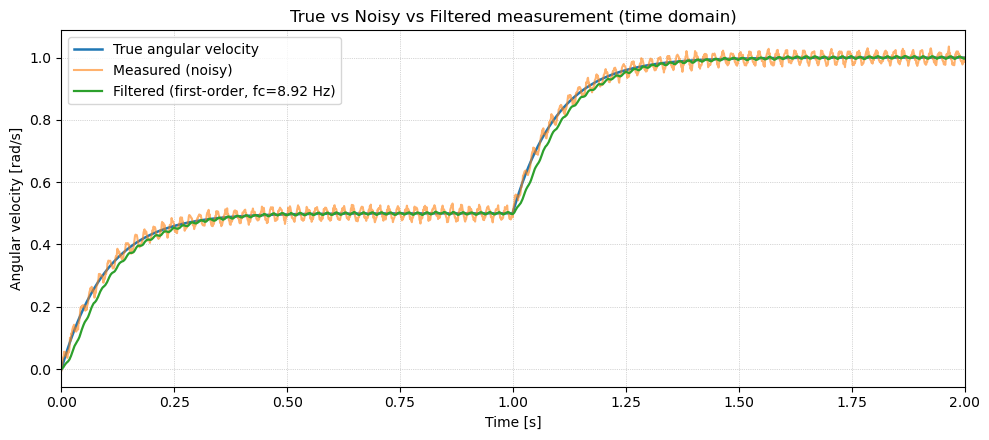

In [6]:
plt.figure(figsize=(10, 4.5))
plt.plot(t, omega, label='True angular velocity', linewidth=1.8)
plt.plot(t, omega_meas, label='Measured (noisy)', alpha=0.6)
plt.plot(t, omega_filt, label=f'Filtered (first-order, fc={fc:.2f} Hz)', linewidth=1.6)
plt.xlim(0, 2.0)
plt.xlabel('Time [s]')
plt.ylabel('Angular velocity [rad/s]')
plt.title('True vs Noisy vs Filtered measurement (time domain)')
plt.legend()
plt.grid(True, which='both', ls=':', lw=0.5)
plt.tight_layout()
plt.show()

### Zoomed view around transient to highlight noise reduction

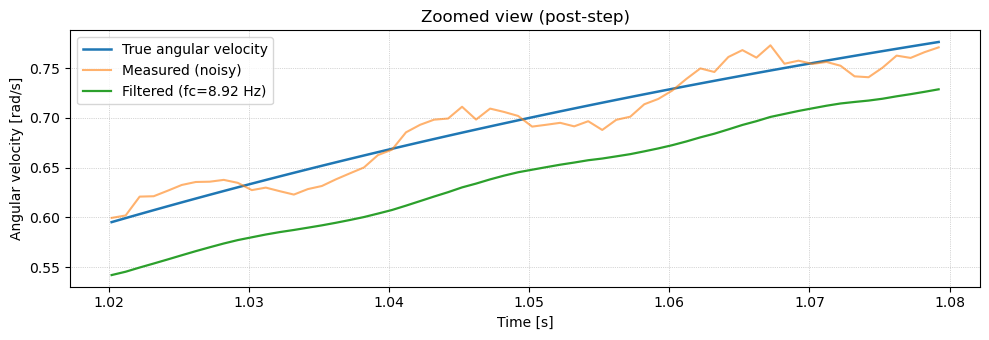

In [7]:
plt.figure(figsize=(10, 3.5))
zoom_idx = (t >= 1.02) & (t <= 1.08)  # shortly after the step change
plt.plot(t[zoom_idx], omega[zoom_idx], label='True angular velocity', linewidth=1.8)
plt.plot(t[zoom_idx], omega_meas[zoom_idx], label='Measured (noisy)', alpha=0.6)
plt.plot(t[zoom_idx], omega_filt[zoom_idx], label=f'Filtered (fc={fc:.2f} Hz)', linewidth=1.6)
plt.xlabel('Time [s]')
plt.ylabel('Angular velocity [rad/s]')
plt.title('Zoomed view (post-step)')
plt.legend()
plt.grid(True, which='both', ls=':', lw=0.5)
plt.tight_layout()
plt.show()

### Frequency response (Bode) for plant and filter (continuous-time)
Evaluate on frequency vector

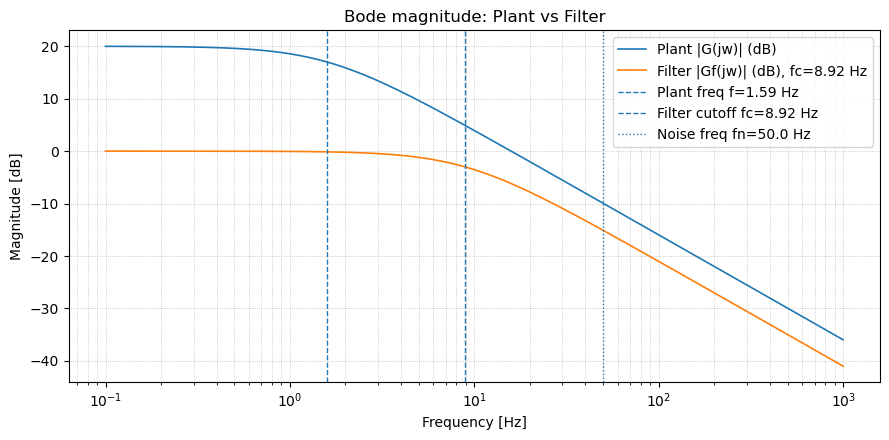

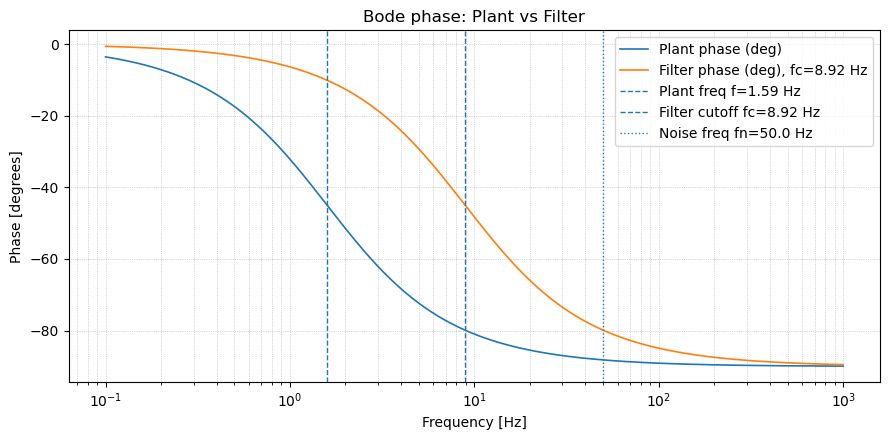

In [8]:
f = np.logspace(-1, 3, 1000)  # 0.1 Hz to 1000 Hz
w = 2 * np.pi * f
s = 1j * w

# Plant frequency response: G(jw) = 1 / (J j w + b)
G = 1.0 / (J * s + b)
Gf = 1.0 / (1.0 + tau_filter * s)

mag_G_db = 20 * np.log10(np.abs(G))
phase_G_deg = np.angle(G, deg=True)
mag_Gf_db = 20 * np.log10(np.abs(Gf))
phase_Gf_deg = np.angle(Gf, deg=True)

# Bode magnitude
plt.figure(figsize=(9, 4.5))
plt.semilogx(f, mag_G_db, label='Plant |G(jw)| (dB)', linewidth=1.2)
plt.semilogx(f, mag_Gf_db, label=f'Filter |Gf(jw)| (dB), fc={fc:.2f} Hz', linewidth=1.2)
plt.axvline(f_sys, linestyle='--', linewidth=1, label=f'Plant freq f={f_sys:.2f} Hz')
plt.axvline(fc, linestyle='--', linewidth=1, label=f'Filter cutoff fc={fc:.2f} Hz')
plt.axvline(fn, linestyle=':', linewidth=1, label=f'Noise freq fn={fn:.1f} Hz')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.title('Bode magnitude: Plant vs Filter')
plt.legend()
plt.grid(True, which='both', ls=':', lw=0.5)
plt.tight_layout()
plt.show()

# Bode phase
plt.figure(figsize=(9, 4.5))
plt.semilogx(f, phase_G_deg, label='Plant phase (deg)', linewidth=1.2)
plt.semilogx(f, phase_Gf_deg, label=f'Filter phase (deg), fc={fc:.2f} Hz', linewidth=1.2)
plt.axvline(f_sys, linestyle='--', linewidth=1, label=f'Plant freq f={f_sys:.2f} Hz')
plt.axvline(fc, linestyle='--', linewidth=1, label=f'Filter cutoff fc={fc:.2f} Hz')
plt.axvline(fn, linestyle=':', linewidth=1, label=f'Noise freq fn={fn:.1f} Hz')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [degrees]')
plt.title('Bode phase: Plant vs Filter')
plt.legend()
plt.grid(True, which='both', ls=':', lw=0.5)
plt.tight_layout()
plt.show()
